<a href="https://colab.research.google.com/github/gaubeur/machine-learning/blob/master/rede_neural_classificacao_de_imagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
import pathlib
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != 'LICENSE.txt'])
CLASS_NAMES

array(['daisy', 'roses', 'sunflowers', 'dandelion', 'tulips'],
      dtype='<U10')

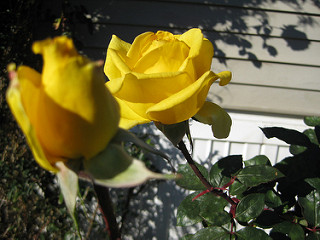

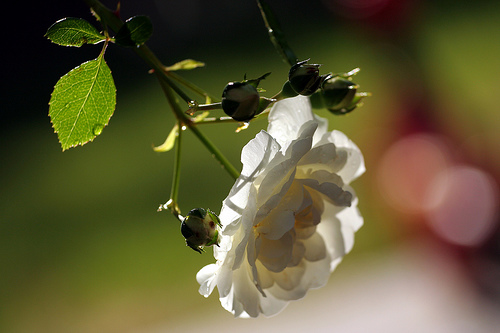

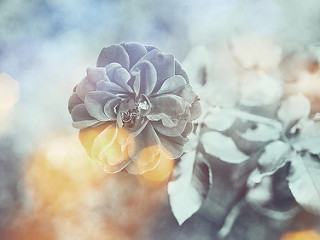

In [ ]:
roses = list(data_dir.glob('roses/*'))

for image_path in roses[:3]:
  display.display(Image.open(str(image_path)))

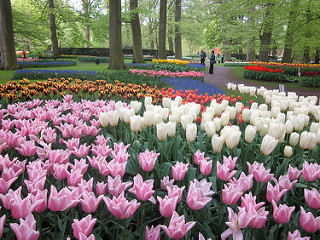

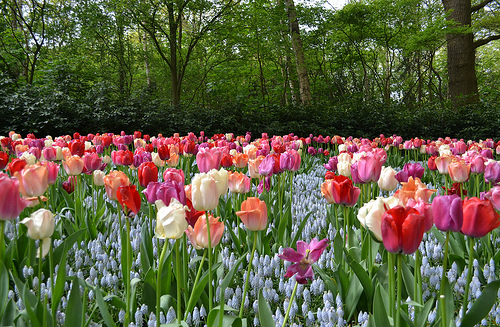

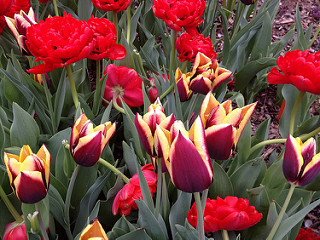

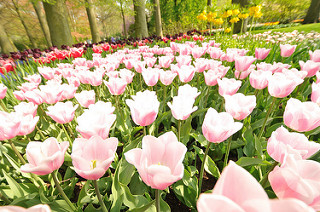

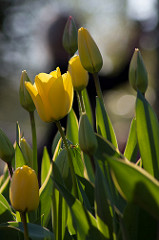

In [ ]:
tulips = list(data_dir.glob('tulips/*'))

for image_path in tulips[:5]:
  display.display(Image.open(str(image_path)))

In [ ]:
# carregar usando Keras.preprocessing
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
#defina alguns parametros para a carga
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [ ]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))


Found 3670 images belonging to 5 classes.


In [ ]:
# inspecione o lote

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')


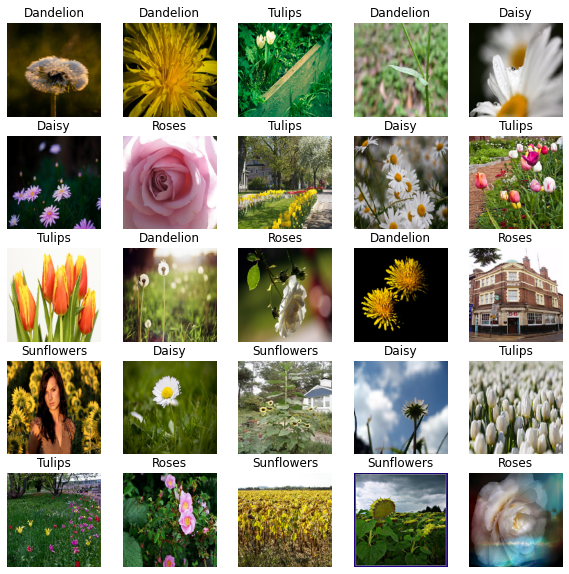

In [ ]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [ ]:
# carregar usando o tf.data
# primeiro crie um conjunto de dados dos caminhos do arquivo
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [ ]:
for f in list_ds.take(5):
  print(f.numpy())

b'/root/.keras/datasets/flower_photos/roses/8394286483_69fe04cc7f.jpg'
b'/root/.keras/datasets/flower_photos/roses/22679076_bdb4c24401_m.jpg'
b'/root/.keras/datasets/flower_photos/roses/6879112993_5a29208438_n.jpg'
b'/root/.keras/datasets/flower_photos/dandelion/6104442744_ee2bcd32e7_n.jpg'
b'/root/.keras/datasets/flower_photos/roses/5840476802_dfa40deb1f_m.jpg'


In [ ]:
# escrever uma funcao pure-tensorflow que converte um caminho de arquivo em um par(img,label)
def get_label(file_path):
  #convert the path to a list of path commponents
  parts = tf.strings.split(file_path, os.path.sep)
  #the secont to last is the class-directory
  return parts[-2] == CLASS_NAMES


In [ ]:
def decode_img(img):
  #convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  #use convert_image_dtype to convert to floats in the [0.1] range
  img = tf.image.convert_image_dtype(img, tf.float32)
  #resize the image to the desired size
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [ ]:
def process_path(file_path):
  label = get_label(file_path)
  #load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# usaremos um Dataset.map para criar um conjunto de dados de image
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [ ]:
for image, label in labeled_ds.take(1):
  print('Imagem: ', image.numpy().shape)
  print('Titulo: ', label.numpy())

Imagem:  (224, 224, 3)
Titulo:  [False False False False  True]


In [ ]:
#metodos básicos para treinamento

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  #this is a small dataset only load it once and keep it in memory
  #use .cache(filename) to cache preprocessing work for dataset that dont´t fit in memory
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()  
  
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  #repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  #prefetch lets the dataset fetch batches in the background while the model is training
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds




In [ ]:
train_ds = prepare_for_training(labeled_ds)

In [ ]:
image_batch, label_batch = next(iter(train_ds))

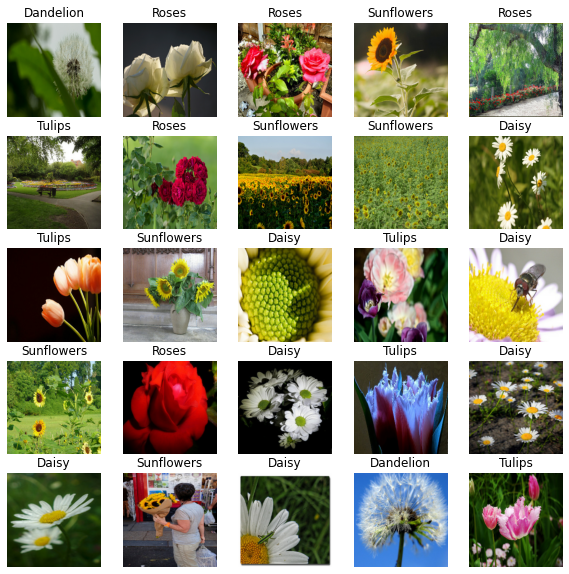

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
#PERFORMANCE
#para investigar, primeiro aqui está uma função para verificar o desempenho de nossos conjuntos de dados

import time
default_timeit_steps = 1000

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.', end='')
  print()    
  end = time.time()

  duration = end-start
  print('{} batches: {} s'.format(steps, duration))
  print('{:0.5f} Images/s'.format(BATCH_SIZE*steps/duration))


In [ ]:
#vamos comparar a velocidade do dois geradores de dados
# keras.preprocessing
timeit(train_data_gen)

....................................................................................................
1000 batches: 103.57142090797424 s
308.96554 Images/s


In [ ]:
#tf_data
timeit(train_ds)

....................................................................................................
1000 batches: 14.68777346611023 s
2178.68284 Images/s


*GRANDE PARTE DO GANHO DE DESEMPENHO VEM DO USO DE CACHE*

In [ ]:
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

....................................................................................................
1000 batches: 69.46232771873474 s
460.68137 Images/s


In [66]:
#se o conjunto de dados não couber na memória , use um aquivo de cache para manter algumas das vantagens

filecache_ds = prepare_for_training(labeled_ds, cache="./flowers.tfcache")
timeit(filecache_ds)

....................................................................................................
1000 batches: 31.70110774040222 s
1009.42845 Images/s
